In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# parameters (from assignment)
beta = 0.3      # transmission rate (week^-1)
alpha = 1.0     # recovery rate (week^-1)
tmax = 100      # simulation time
h = 0.1         # timestep for Euler's method

# geometric degree distribution: p_k = p(1-p)^k with p = 1/4
p = 0.25
max_k = 50      # maximum degree to consider
total_nodes = 10000  # total population size

# generate geometric degree distribution
degree_freq = []
for k in range(max_k):
    p_k = p * (1 - p)**k
    n_k = total_nodes * p_k
    degree_freq.append(int(n_k))

G_deg_sum = [a * b for a, b in zip(degree_freq, range(0, len(degree_freq)))]
total_degree = sum(G_deg_sum)
N = sum(degree_freq)
avg_k = total_degree / N if N > 0 else 0

print(f"Network Statistics:")
print(f"  Total nodes: {N}")
print(f"  Average degree: {avg_k:.3f}")
print(f"  Max degree: {max_k}")
print(f"  Degree distribution: {degree_freq[:30]}...")

Network Statistics:
  Total nodes: 9984
  Average degree: 2.976
  Max degree: 50
  Degree distribution: [2500, 1875, 1406, 1054, 791, 593, 444, 333, 250, 187, 140, 105, 79, 59, 44, 33, 25, 18, 14, 10, 7, 5, 4, 3, 2, 1, 1, 1, 0, 0]...


In [ ]:
def ODES_SIS_unvaccinated(S_k, I_k, beta, alpha, k, theta):
    """
    Base SIS equations WITHOUT vaccination (from part a)
    
    Parameters:
    -----------
    S_k: float
        Number of susceptible individuals with degree k
    I_k: float
        Number of infected individuals with degree k
    beta : float
        Transmission rate
    alpha : float
        Recovery rate
    k : int
        Degree class
    theta : float
        Probability that a random edge points to an infected node
    
    Returns:
    --------
    tuple : (dS, dI)
        Rate of change for S and I
    """
    dI = S_k * k * theta * beta - alpha * I_k # exactly the same as the SIS equations from part a
    dS = -beta * k * theta * S_k + alpha * I_k  # infection out, recovery in
    
    return dS, dI


def ODES_SIS_vaccinated(S_U, I_U, S_V, I_V, beta, alpha, k, theta, rho):
    """
    SIS equations WITH vaccination (from part b)
    
    Parameters:
    -----------
    S_U, I_U : Unvaccinated susceptible and infected with degree k
    S_V (S_k^V), I_V (I_k^V) : Vaccinated susceptible and infected with degree k
    theta : Modified probability accounting for reduced transmission
    """
    # unvaccinated equations
    dS_U = -beta * k * theta * S_U + alpha * I_U
    dI_U = S_U * k * theta * beta - alpha * I_U # exactly the same as the SIS equations from part b

    # vaccinated equations (transmission reduced by factor 1-ρ)
    dS_V = -(1 - rho) * beta * k * theta * S_V + alpha * I_V
    dI_V = S_V * (1 - rho) * k * theta * beta - alpha * I_V # exactly the same as the SIS equations from part b
    return dS_U, dI_U, dS_V, dI_V

In [ ]:
def run_hmf_vaccination(rho, vaccinate_high_degree=False, vaccination_fraction=0.4):
    """    
    Parameters:
    -----------
    rho : float
        Vaccination efficacy (0 = no effect, 1 = perfect protection)
    vaccinate_high_degree : bool
        If True, vaccinate highest degree nodes first (part d)
        If False, vaccinate randomly across all degrees (part c)
    vaccination_fraction : float
        Fraction of population to vaccinate (default 0.4 = 40%)
    
    Returns:
    --------
    tuple : (T, St, It)
        Time array, susceptible fraction over time, infected fraction over time
    """
    # initial conditions
    I0 = 0.01           # Initial fraction infected
    S0 = 1.0 - I0       # Initial fraction susceptible
    
    # Initialize arrays for each degree class
    S_U_k = np.zeros(len(degree_freq))  # Unvaccinated susceptible
    I_U_k = np.zeros(len(degree_freq))  # Unvaccinated infected
    S_V_k = np.zeros(len(degree_freq))  # Vaccinated susceptible
    I_V_k = np.zeros(len(degree_freq))  # Vaccinated infected
    
    # Populate initial conditions
    for k in range(len(degree_freq)):
        S_U_k[k] = degree_freq[k] * S0
        I_U_k[k] = degree_freq[k] * I0
        S_V_k[k] = 0.0
        I_V_k[k] = 0.0
    
    # c and d
    if vaccinate_high_degree:
        # Targeted vaccination
        total_to_vaccinate = N * vaccination_fraction
        vaccinated_count = 0
        
        # (-1, -1, -1): begin with highest degree nodes, stops at index 0, decrements by 1 each iteration
        for k in range(len(degree_freq)-1, -1, -1):
            if vaccinated_count >= total_to_vaccinate:
                break

            # example: if degree_freq[k] = 1000, total_to_vaccinate = 4000, vaccinated_count = 0
            # nodes_to_vaccinate = min(1000, 4000 - 0) = 1000
            # fraction_to_vaccinate = 1000 / 1000 = 1
            # S_V_k[k] = S_U_k[k] * 1 = 1000
            # S_U_k[k] = S_U_k[k] * (1 - 1) = 0
            nodes_to_vaccinate = min(
                degree_freq[k], 
                total_to_vaccinate - vaccinated_count
            )
            fraction_to_vaccinate = nodes_to_vaccinate / degree_freq[k] if degree_freq[k] > 0 else 0
            S_V_k[k] = S_U_k[k] * fraction_to_vaccinate
            S_U_k[k] = S_U_k[k] * (1 - fraction_to_vaccinate)
            
            vaccinated_count += nodes_to_vaccinate
    else:
        # Random vaccination
        for k in range(len(degree_freq)):
            S_V_k[k] = S_U_k[k] * vaccination_fraction
            S_U_k[k] = S_U_k[k] * (1 - vaccination_fraction)
    
    # euler's method
    res = []
    T = np.arange(0, tmax/h)
    
    for t in T:
        # Calculate modified theta from part (b)
        numerator = sum(k * (I_U_k[k] + (1 - rho) * I_V_k[k]) for k in range(len(degree_freq))) # exactly the same as the numerator in theta calculation from part b
        denominator = total_degree
        theta = numerator / denominator if denominator > 0 else 0
        
        # Update each degree class
        for k in range(len(degree_freq)):
            dS_U, dI_U, dS_V, dI_V = ODES_SIS_vaccinated(
                S_U_k[k], I_U_k[k], S_V_k[k], I_V_k[k], 
                beta, alpha, k, theta, rho
            )
            
            # Euler's method
            S_U_k[k] += dS_U * h
            I_U_k[k] += dI_U * h
            S_V_k[k] += dS_V * h
            I_V_k[k] += dI_V * h
        
        # Track totals
        S_total = np.sum(S_U_k) + np.sum(S_V_k)
        I_total = np.sum(I_U_k) + np.sum(I_V_k)
        
        res.append((S_total/N, I_total/N))
    
    St, It = map(np.array, zip(*res))
    return h*T, St, It

ρ = 0.00: Peak I = 0.2164, Final S = 0.7836
ρ = 0.30: Peak I = 0.1447, Final S = 0.8553
ρ = 0.50: Peak I = 0.0990, Final S = 0.9010
ρ = 0.70: Peak I = 0.0639, Final S = 0.9361
ρ = 0.90: Peak I = 0.0441, Final S = 0.9559
ρ = 0.95: Peak I = 0.0414, Final S = 0.9586
ρ = 0.99: Peak I = 0.0399, Final S = 0.9601
ρ = 0.00: Peak I = 0.2164, Final S = 0.7836
ρ = 0.30: Peak I = 0.0208, Final S = 0.9792
ρ = 0.50: Peak I = 0.0095, Final S = 1.0000
ρ = 0.70: Peak I = 0.0094, Final S = 1.0000
ρ = 0.90: Peak I = 0.0092, Final S = 1.0000
ρ = 0.95: Peak I = 0.0092, Final S = 1.0000
ρ = 0.99: Peak I = 0.0092, Final S = 1.0000


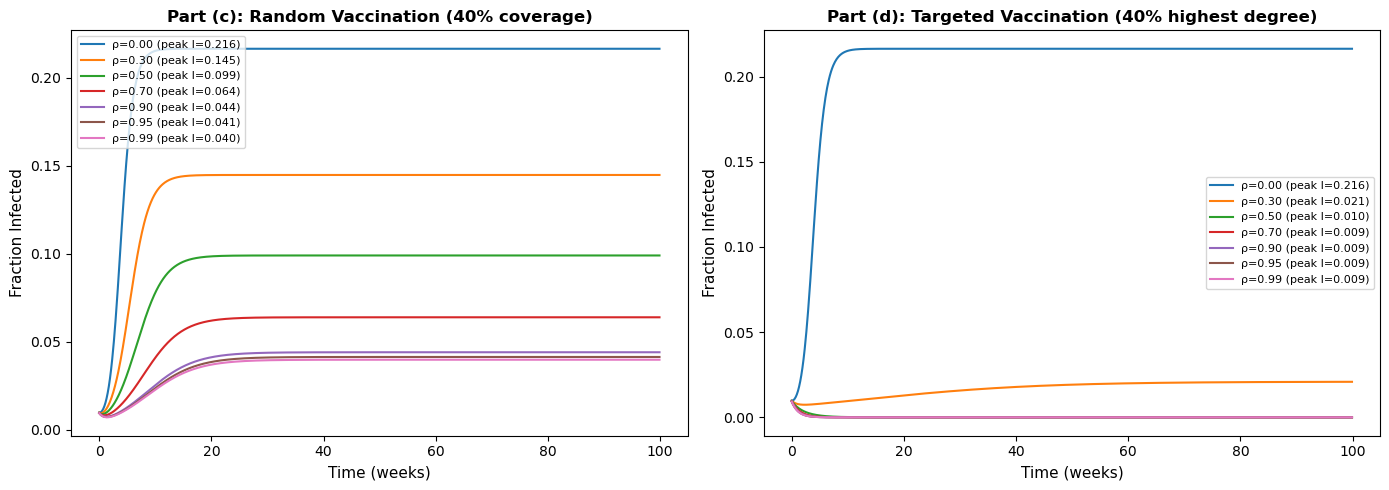

In [70]:
rho_values = [0.0, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# random vaccination
for rho in rho_values:
    T, St, It = run_hmf_vaccination(rho, vaccinate_high_degree=False)
    peak_I = np.max(It)
    final_S = St[-1]
    
    axes[0].plot(T, It, label=f'ρ={rho:.2f} (peak I={peak_I:.3f})')
    print(f"ρ = {rho:.2f}: Peak I = {peak_I:.4f}, Final S = {final_S:.4f}")

axes[0].set_xlabel('Time (weeks)', fontsize=11)
axes[0].set_ylabel('Fraction Infected', fontsize=11)
axes[0].set_title('Part (c): Random Vaccination (40% coverage)', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=8)

# target high degree nodes
for rho in rho_values:
    T, St, It = run_hmf_vaccination(rho, vaccinate_high_degree=True)
    peak_I = np.max(It)
    final_S = St[-1]
    
    axes[1].plot(T, It, label=f'ρ={rho:.2f} (peak I={peak_I:.3f})')
    print(f"ρ = {rho:.2f}: Peak I = {peak_I:.4f}, Final S = {final_S:.4f}")

axes[1].set_xlabel('Time (weeks)', fontsize=11)
axes[1].set_ylabel('Fraction Infected', fontsize=11)
axes[1].set_title('Part (d): Targeted Vaccination (40% highest degree)', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('vaccination_comparison_SIS.png', dpi=150, bbox_inches='tight')
plt.show()